In [ ]:
# If pulled changes from github are not reflected, uncomment this code block. 
# Furthermore, restart all of your runtimes. 
# Colab sometimes seems to cache executed code from github, not using the latest pulled changes.
# %cd /content
# !rm -rf *

## Download our dataset from our Dropbox and our main dependencies
Make sure to add all newly created data to the `combined_jsons` folder in our shared dropbox. The data will be directly curled from it.

In [ ]:
import os

REPO = "confusion_detection"
%cd /content

if not os.path.exists(f"/content/{REPO}"):
  !rm -rf *
  !git clone https://github.com/leomorpho/confusion_detection.git
  %cd confusion_detection
else:
  %cd /content
  %cd confusion_detection
  !git fetch --all
  !git reset --hard origin/master

assert(os.getcwd() == "/content/confusion_detection")

/content
/content
/content/confusion_detection
Fetching origin
HEAD is now at 767ef19 Update READMEs


## Preprocess

In [ ]:
from glob import glob
from typing import *
import json

DATA_DIR = "data/combined_jsons"
dataset_paths = glob(f"{DATA_DIR}/*")
print("dataset_paths is: ", dataset_paths)
print("dataset_paths count is: ", len(dataset_paths))

length_75 = []
length_55 = []
length_75_count = 0
length_55_count = 0
length_unknown = []
length_unknown_count = 0
indeces_to_pop = []
# Create single list object from all the JSONs
raw_sequences: List[List[List[float]]] = []
for path in dataset_paths:
  with open(path, "r") as f:
    sequences = json.loads(f.read())
    for seq in sequences:
      if len(seq) > 55:
        length_75_count += 1
        length_75.append([path, seq])
      elif len(seq) == 55:
        length_55_count += 1
        length_55.append([path, seq])
      else:
        length_unknown_count += 1
        length_unknown.append([path, seq])
    raw_sequences.append(sequences)

# Remove all frames that do not have 55 features (Confusion Score + 54 OpenPose points)
for i in range(len(raw_sequences)):
  for j in range(len(raw_sequences[i])):
    if len(raw_sequences[i][len(raw_sequences[i])-j-1]) != 55:
      # print("not 55: ", len(raw_sequences[i][len(raw_sequences[i])-j-1]))
      indeces_to_pop.append([i, len(raw_sequences[i])-j-1])


print("Number of indeces to pop: ", len(indeces_to_pop))
for (i, j) in sorted(indeces_to_pop, reverse=True):
  raw_sequences[i].pop(j)


print("length_75_count is: ", length_75_count)
print("length_55_count is: ", length_55_count)
print("length_unknown_count is: ", length_unknown_count)
print("length of raw_sequences is: ", len(raw_sequences))

# print("length_75 is: ", len(length_75))
# print("length_55 is: ", len(length_55))
# print("length_unknown is: ", len(length_unknown))

# for (path, seq) in length_75:
#   print("length_75 is: ", path)

# for (path, seq) in length_unknown:
#   print("length_unknown is: ", path)
# #   print("length is: ", len(seq))


dataset_paths is:  ['data/combined_jsons/2019-10-15-14-15-19bag_img_raw_04_combined.json', 'data/combined_jsons/2019-10-16-14-12-40bag_img_raw_01_combined.json', 'data/combined_jsons/2019-10-15-14-22-48bag_img_raw_04_combined.json', 'data/combined_jsons/2019-10-15-14-15-19bag_img_raw_01_combined.json', 'data/combined_jsons/2019-10-24-14-32-29bag_img_raw_01_combined.json', 'data/combined_jsons/2019-10-15-14-12-10bag_img_raw_04_combined.json', 'data/combined_jsons/2019-10-24-15-05-09bag_img_raw_03_combined.json', 'data/combined_jsons/2019-10-10-14-24-28bag_img_raw_04_combined.json', 'data/combined_jsons/2019-10-24-14-25-07bag_img_raw_04_combined.json', 'data/combined_jsons/2019-10-24-15-05-09bag_img_raw_01_combined.json', 'data/combined_jsons/2019-10-24-15-21-13bag_img_raw_03_combined.json', 'data/combined_jsons/2019-11-05-14-14-31bag_img_raw_03_combined.json', 'data/combined_jsons/2019-12-05-14-20-24bag_img_raw_04_combined.json', 'data/combined_jsons/2019-12-05-15-15-46bag_img_raw_01_co

In [ ]:
number_of_zeroes = 0
number_of_ones = 0
number_of_twos = 0
number_of_threes = 0
total_count = 0

for sequence in raw_sequences:
  for frame in sequence:
    total_count += 1
    if int(frame[0]) == 0:
      number_of_zeroes += 1
    elif int(frame[0]) == 1:
      number_of_ones += 1
    elif int(frame[0]) == 2:
      number_of_twos += 1
    elif int(frame[0]) == 3:
      number_of_threes += 1

print(f"0: {number_of_zeroes}")
print(f"1: {number_of_ones}")
print(f"2: {number_of_twos}")
print(f"3: {number_of_threes}")
print(f"total_count: {total_count}")
print(f"total_count - number_of_zeroes: {total_count - number_of_zeroes}")

0: 3955
1: 16081
2: 11363
3: 11445
total_count: 42844
total_count - number_of_zeroes: 38889


Get centroid for every frame. If the centroid differs widely between 2 frames, it may indicate that different people were picked up by OpenPose.
Centroid code taken from [here](https://stackoverflow.com/questions/23020659/fastest-way-to-calculate-the-centroid-of-a-set-of-coordinate-tuples-in-python-wi).

Format of OpenPose output can be found [here](https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/output.md). A frame is represented by `x1,y1,c1,x2,y2,c2,...`

If a dropped frame is between 2 valid sequences, consider stitching them back together.
* Drop frames which have **no subject** in them. DONE.
* Drop frames which have **wrong** subject in them.  DONE.
* Give unit variance and zero mean to all points. DONE.

In [ ]:
from jupyter_tools.preprocessing import stitch_frames, normalize

print(f"Number of raw sequences:        {len(raw_sequences)}")
parsed_sequences = stitch_frames(raw_sequences, min_dist=50, min_sequence_len=40, max_dropped_frames=4)
print(f"Number of stitched sequences:   {len(parsed_sequences)}")
normalized_sequences = normalize(parsed_sequences)
print(f"Number of normalized sequences: {len(normalized_sequences)}")

# CAUTION: further code should ONLY refer to "preprocessed_sequences".
# This prevent breakages if code changes.
preprocessed_sequences = normalized_sequences

Number of raw sequences:        146
Number of stitched sequences:   201
Number of normalized sequences: 201


In [ ]:
# Get some info on preprocessed_sequences
number_of_zeroes = 0
number_of_ones = 0
number_of_twos = 0
number_of_threes = 0
total_count = 0

for sequence in preprocessed_sequences:
  for frame in sequence:
    total_count += 1
    if int(frame[0]) == 0:
      number_of_zeroes += 1
    elif int(frame[0]) == 1:
      number_of_ones += 1
    elif int(frame[0]) == 2:
      number_of_twos += 1
    elif int(frame[0]) == 3:
      number_of_threes += 1

print(f"0: {number_of_zeroes}")
print(f"1: {number_of_ones}")
print(f"2: {number_of_twos}")
print(f"3: {number_of_threes}")
print(f"total_count: {total_count}")
print(f"total_count - 0's: {total_count - number_of_zeroes}")

0: 0
1: 9461
2: 6817
3: 8135
total_count: 24413
total_count - 0's: 24413


In [ ]:
import pandas as pd

# Get some stats about the length of the processed sequences
sequences_len = []
for sequence in preprocessed_sequences:
  sequences_len.append(len(sequence))

a = pd.DataFrame(sequences_len)
a.describe()

,0
count,201.000000
mean,121.457711
std,102.400388
min,40.000000
25%,54.000000
50%,84.000000
75%,143.000000
max,683.000000


## Model
Create 3 models
* Simple RNN
* LSTM/GRU RNN

For testing, it would be beneficial to write a function (in `jupyter_tools`) to display the frames as a video with a label indicating the prediction from the model.

First, we need to extract the X and Y values from our dataset in order to use them on the model.
Our Y will be our confusion annotations, and our X will be all the openPose coordinates.

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

nn_input_data = np.asarray(preprocessed_sequences)

nn_data = []
nn_target = []
# Split the data into data and target arrays
for row in range(len(nn_input_data)):
    for frame in range(len(nn_input_data[row])):
        target = nn_input_data[row][frame][0]
        data = []
        for datum in nn_input_data[row][frame][1:]:
          data.append(datum)
        # data = nn_input_data[row][frame][1:]
        nn_data.append(data)
        nn_target.append(target)
print("done")

done


In [ ]:
## Because we have stripped away all 0s from the Confusion Score,
## The target set must now be reduced from 1-3 to 0-2, to play nicely with the models
nn_target_reduced = []
target_counts = [0,0,0]
print("Previous Values: ", nn_target[0:10])
for i in range(len(nn_target)):
  if nn_target[i] == 3:
    nn_target_reduced.append(2)
    target_counts[2] += 1
  elif nn_target[i] == 2:
    nn_target_reduced.append(1)
    target_counts[1] += 1
  elif nn_target[i] == 1:
    nn_target_reduced.append(0)
    target_counts[0] += 1
  else:
    print("found invalid value: ", nn_target[i])

print(" Current Values: ", nn_target_reduced[0:10])

print("Target Counts for the three possible scores: ", target_counts)

Previous Values:  [3, 2, 3, 2, 3, 2, 3, 2, 3, 2]
 Current Values:  [2, 1, 2, 1, 2, 1, 2, 1, 2, 1]
Target Counts for the three possible scores:  [9461, 6817, 8135]


In [ ]:
nn_data_np = np.asarray(nn_data)
nn_target_np = np.asarray(nn_target_reduced)
nn_data_pd = pd.DataFrame(nn_data)
nn_target_pd = pd.DataFrame(nn_target_reduced)

print("nn_data_pd shape is: ", nn_data_pd.shape)
print("nn_data_pd type is: ",nn_data_np.dtype)

# print(nn_data_np[0])

nn_data_pd shape is:  (24413, 54)
nn_data_pd type is:  float64


### Statistics for the data
There are currently 54 features

In [ ]:
nn_data_pd.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
count,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000,24413.000000
mean,0.417873,-0.297094,-1.053940,1.083413,0.035283,-1.052703,1.072625,0.034763,-1.052886,1.051182,0.235870,-1.053587,0.908857,0.183556,-1.054089,1.095205,0.033153,-1.052842,1.083589,0.239692,-1.053377,0.874002,0.175511,-1.053968,1.079980,0.477647,-1.053304,1.074993,0.783179,-1.053157,1.021614,0.990829,-1.053520,1.094646,0.478195,-1.053264,1.083358,0.784052,-1.053111,1.027648,0.996311,-1.053517,0.333928,-0.486303,-1.054806,0.245490,-0.456388,-1.054533,0.534970,-0.408751,-1.054504,0.415528,-0.333242,-1.054054
std,1.021192,0.445021,0.129619,0.428562,0.346639,0.130106,0.452394,0.344282,0.130000,0.497909,0.429407,0.130031,0.738571,0.550247,0.129878,0.433374,0.348547,0.130065,0.482692,0.444039,0.130046,0.743688,0.565759,0.129806,0.422975,0.508356,0.129961,0.432282,0.631517,0.130060,0.541908,0.811478,0.130192,0.405097,0.511771,0.129949,0.414942,0.637933,0.130043,0.529405,0.826989,0.130163,1.090346,0.462418,0.129660,1.042646,0.486452,0.129591,1.062971,0.491407,0.130234,1.000101,0.517211,0.130142
min,-1.257885,-1.109977,-1.398062,-0.573959,-0.610912,-1.395453,-0.803860,-0.712949,-1.395578,-1.113973,-1.113973,-1.396565,-1.269707,-1.269707,-1.396903,-0.916112,-0.916112,-1.395838,-1.193997,-1.193997,-1.397485,-1.290381,-1.290381,-1.398563,-0.689930,-0.654779,-1.395489,-1.198909,-1.198909,-1.396956,-1.258818,-1.258818,-1.397627,-0.903579,-0.903579,-1.395237,-1.147322,-1.147322,-1.396947,-1.273625,-1.273625,-1.397610,-1.291374,-1.291374,-1.398303,-1.274216,-1.274216,-1.398172,-1.291909,-1.291909,-1.398606,-1.292659,-1.292659,-1.397956
25%,-0.823395,-0.470610,-1.139929,0.981120,-0.236067,-1.139525,0.959321,-0.232283,-1.139630,0.933063,-0.071605,-1.140499,0.784045,-0.092833,-1.140497,0.986601,-0.240911,-1.139591,0.959460,-0.084507,-1.140150,0.698049,-0.116271,-1.140113,0.987560,0.091328,-1.140043,0.987688,0.304361,-1.139791,0.959148,0.472105,-1.140291,0.991529,0.088482,-1.140017,0.984436,0.300728,-1.139800,0.938273,0.465410,-1.139959,-0.961086,-0.961086,-1.140926,-0.956067,-0.956067,-1.140635,-0.923937,-0.923937,-1.141010,-0.932718,-0.932718,-1.141011
50%,1.017858,-0.283905,-1.057964,1.230301,-0.058506,-1.056334,1.205793,-0.054772,-1.056476,1.186099,0.142024,-1.057104,1.164886,0.139155,-1.057923,1.243831,-0.060233,-1.056481,1.248895,0.135956,-1.056859,1.175508,0.113399,-1.057379,1.211973,0.360119,-1.056899,1.213204,0.656029,-1.056699,1.204378,0.885535,-1.057084,1.238227,0.358626,-1.056893,1.234501,0.653521,-1.056726,1.221098,0.889094,-1.057162,0.977670,-0.414595,-1.059091,0.718160,-0.412839,-1.058578,1.123562,-0.348407,-1.058174,0.931528,-0.271813,-1.057733
75%,1.281385,-0.029529,-0.981405,1.352876,0.261476,-0.980206,1.352565,0.257128,-0.980325,1.356213,0.468252,-0.981002,1.384972,0.480577,-0.981346,1.377656,0.262540,-0.980345,1.392998,0.509610,-0.981177,1.369862,0.492571,-0.981842,1.341283,0.747395,-0.980798,1.339158,1.067593,-0.980391,1.332694,1.346058,-0.980785,1.356764,0.749507,-0.980725,1.351186,1.073478,-0.980346,1.339504,1.348264,-0.980693,1.306755,-0.200112,-0.982009,1.232735,-0.139623,-0.982275,1.354909,-0.109665,-0.981454,1.261196,0.032490,-0.981936
max,1.838729,1.070167,-0.243291,2.9627

In [ ]:
nn_target_pd.describe()

,0
count,24413.000000
mean,0.945685
std,0.847256
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


Next, apply the data to the Models

1.   Simple Sequential NN
2.   LSTM



In [ ]:
# Split the data into training and test sets
twenty_percent_split = int(np.floor(len(nn_data_np) * 0.8))
x_train_split = nn_data_np[0:twenty_percent_split]
x_test_split = nn_data_np[twenty_percent_split:]
y_train_split = nn_target_np[0:twenty_percent_split]
y_test_split = nn_target_np[twenty_percent_split:]

# Split the training set into train & validation
twenty_percent_validate_split = int(np.floor(len(x_train_split) * 0.8))
x_train = x_train_split[0:twenty_percent_validate_split]
x_validate = x_train_split[twenty_percent_validate_split:]
y_train = y_train_split[0:twenty_percent_validate_split]
y_validate =  y_train_split[twenty_percent_validate_split:]

print("x_train length is: ", len(x_train))
print("x_validate length is: ", len(x_validate))
print("x_test_split length is: ", len(x_test_split))

x_train length is:  15624
x_validate length is:  3906
x_test_split length is:  4883


SNN

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

# Build the model, compile it, and run the training
snn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

snn_model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

snn_history = snn_model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2, validation_data=(x_validate, y_validate))

Epoch 1/10
15624/15624 - 14s - loss: 1.0914 - accuracy: 0.3648 - val_loss: 1.0817 - val_accuracy: 0.4391
Epoch 2/10
15624/15624 - 14s - loss: 1.0880 - accuracy: 0.3657 - val_loss: 1.0951 - val_accuracy: 0.3175
Epoch 3/10
15624/15624 - 14s - loss: 1.0845 - accuracy: 0.3740 - val_loss: 1.0954 - val_accuracy: 0.3226
Epoch 4/10
15624/15624 - 14s - loss: 1.0813 - accuracy: 0.3877 - val_loss: 1.0948 - val_accuracy: 0.3676
Epoch 5/10
15624/15624 - 14s - loss: 1.0743 - accuracy: 0.4064 - val_loss: 1.0923 - val_accuracy: 0.3597
Epoch 6/10
15624/15624 - 14s - loss: 1.0702 - accuracy: 0.4075 - val_loss: 1.0982 - val_accuracy: 0.3991
Epoch 7/10
15624/15624 - 13s - loss: 1.0688 - accuracy: 0.4114 - val_loss: 1.1196 - val_accuracy: 0.3840
Epoch 8/10
15624/15624 - 13s - loss: 1.0661 - accuracy: 0.4167 - val_loss: 1.1254 - val_accuracy: 0.4334
Epoch 9/10
15624/15624 - 13s - loss: 1.0667 - accuracy: 0.4126 - val_loss: 1.0883 - val_accuracy: 0.4465
Epoch 10/10
15624/15624 - 13s - loss: 1.0636 - accuracy

In [ ]:
# Get the target predictions for the test set on the trained model
predict_snn = snn_model.predict(x_test_split)

In [ ]:
# Round and print prediction array to see the results of our model's prediction ability
rounded_predict = []
correctness = [[0, 0], [0, 0, 0]]
target_correctness = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
for i in range(len(predict_snn)):
  rounded = []
  for j in range(len(predict_snn[i])):
    rounded.append(round(predict_snn[i][j], 3))
  
  # check if the prediction was correct or not
  if predict_snn[i][y_test_split[i]] == max(predict_snn[i]):
    correctness[0][0] += 1
    correctness[0][1] += predict_snn[i][y_test_split[i]]
    target_correctness[y_test_split[i]][0] += 1
  else:
    correctness[1][0] += 1
    correctness[1][1] += predict_snn[i][y_test_split[i]]
    correctness[1][2] += max(predict_snn[i])
    target_correctness[y_test_split[i]][1] += 1
  rounded_predict.append(rounded)

# compare actual score vs prediction for a subset of the array
# for i in range(1,80):
#   print(y_test_split[i], rounded_predict[i][y_test_split[i]])

# Calculate the means for the predictions of correct and incorrect predictions
correctness[0][1] = correctness[0][1] / correctness[0][0]
correctness[1][1] = correctness[1][1] / correctness[1][0]
correctness[1][2] = correctness[1][2] / correctness[1][0]
percent_correct = correctness[0][0] / (correctness[0][0]+correctness[1][0])
target_correctness[0][2] = target_correctness[0][0] / (target_correctness[0][0]+target_correctness[0][1])
target_correctness[1][2] = target_correctness[1][0] / (target_correctness[1][0]+target_correctness[1][1])
target_correctness[2][2] = target_correctness[2][0] / (target_correctness[2][0]+target_correctness[2][1])

print("Results: ", correctness)
print("Percentage Correct: ", percent_correct*100)
print("Predictions per target value: ", target_correctness)
# print((correctness[0][0]+correctness[1][0]), len(predict_snn))

Results:  [[1786, 0.41275527470923484], [3097, 0.2911029939324986, 0.41257233297513074]]
Percentage Correct:  36.57587548638132
Predictions per target value:  [[1033, 978, 0.513674788662357], [30, 1416, 0.02074688796680498], [723, 703, 0.5070126227208976]]


In [ ]:
# Print the max & min values for prediction of each confusion score
prediction_max = [0,0,0]
prediction_min = [1,1,1]
for i in range(len(rounded_predict)):
  for k in range(len(rounded_predict[i])):
    if predict_snn[i][k] > prediction_max[k]:
      prediction_max[k] = predict_snn[i][k]
    if predict_snn[i][k] < prediction_min[k]:
      prediction_min[k] = predict_snn[i][k]

print("max probability predictions: ", prediction_max)
print("min probability predictions: ", prediction_min)

max probability predictions:  [0.8430253, 0.9999995, 0.44949442]
min probability predictions:  [5.0348626e-07, 0.03663271, 4.0586715e-11]


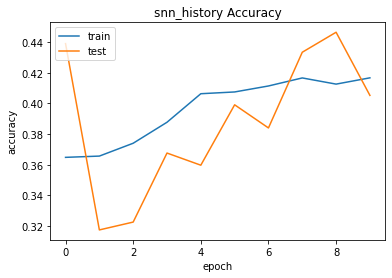

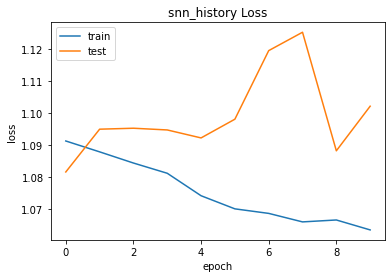

       loss  accuracy  val_loss  val_accuracy
0  1.091390  0.364823  1.081707      0.439068
1  1.087992  0.365655  1.095076      0.317460
2  1.084500  0.374040  1.095376      0.322581
3  1.081300  0.387737  1.094839      0.367640
4  1.074278  0.406362  1.092347      0.359703
5  1.070178  0.407514  1.098200      0.399130
6  1.068759  0.411418  1.119631      0.384025
7  1.066101  0.416667  1.125376      0.433436
8  1.066700  0.412634  1.088322      0.446493
9  1.063594  0.416731  1.102258      0.405274


In [ ]:
## Visualize Results      source: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

# summarize snn_history for accuracy
plt.plot(snn_history.history['accuracy'])
plt.plot(snn_history.history['val_accuracy'])
plt.title('snn_history Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize snn_history for loss
plt.plot(snn_history.history['loss'])
plt.plot(snn_history.history['val_loss'])
plt.title('snn_history Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

history_pd = pd.DataFrame(snn_history.history)
print(history_pd)

**Create a 3D array with a constant step-size for the LSTM**

In [ ]:
import numpy as np

number_of_features = 54
window_size = 10
window_size_array_x = []
window_size_array_y = []
index = 0
while index <= len(nn_data):
  if index+window_size > len(nn_data):
    break
  data_x = []
  data_y = []
  for i in range(index, index+window_size, 1):
    data_x.append(tf.convert_to_tensor(nn_data[i][:number_of_features]))
    data_y.append(tf.convert_to_tensor(nn_target_reduced[i]))
  window_size_array_x.append(data_x)
  window_size_array_y.append(data_y)
  index += window_size

print("done")

done


### Train Model

In [ ]:
## THIS CELL TAKES QUITE A WHILE TO PROCESS (just a heads up)

# Split the data into training and test sets
twenty_percent_split = int(np.floor(len(window_size_array_x) * 0.8))
x_train_split = window_size_array_x[0:twenty_percent_split]
x_test_split = window_size_array_x[twenty_percent_split:]
y_train_split = window_size_array_y[0:twenty_percent_split]
y_test_split = window_size_array_y[twenty_percent_split:]

# Split Train set into train & validation
twenty_percent_validate_split = int(np.floor(len(x_train_split) * 0.8))
x_train_temp = x_train_split[0:twenty_percent_validate_split]
x_validate = x_train_split[twenty_percent_validate_split:]
y_train_temp = y_train_split[0:twenty_percent_validate_split]
y_validate =  y_train_split[twenty_percent_validate_split:]
print("arrays have been split")

# Convert the arrays into npArrays
x_train_lstm = np.asarray(x_train_temp)
print("x_train_temp has been converted to np")
x_validate_lstm = np.asarray(x_validate)
print("x_validate has been converted to np")
x_test_lstm = np.asarray(x_test_split)
print("x_test1 has been converted to np")
y_train_lstm = np.asarray(y_train_temp)
print("y_train_temp has been converted to np")
y_validate_lstm = np.asarray(y_validate)
print("y_validate has been converted to np")
y_test_lstm = np.asarray(y_test_split)
print("y_test1 has been converted to np")

print("x_train_lstm shape is: ", x_train_lstm.shape)
print("x_validate_lstm shape is: ", x_validate_lstm.shape)

arrays have been split
x_train_temp has been converted to np
x_validate has been converted to np
x_test1 has been converted to np
y_train_temp has been converted to np
y_validate has been converted to np
y_test1 has been converted to np
x_train_lstm shape is:  (1561, 10, 54)
x_validate_lstm shape is:  (391, 10, 54)


Simple LSTM

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

# We could potentially use EarlyStopping to limit required amount of epochs with: ,callbacks = [early_stopping]
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=4, mode='auto')

# As a general rule-of-thumb, the number of hidden layers should roughly equal Ns / (alpha*(Ni+No))
hidden_nodes = int(len(x_train_lstm) / (6 * (54+3)))
print("number of hidden nodes: ", hidden_nodes)

simple_lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(hidden_nodes, return_sequences=True),
    tf.keras.layers.Dense(3, activation='softmax')
])

simple_lstm_model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

simple_lstm_history = simple_lstm_model.fit(x_train_lstm, y_train_lstm, 
               batch_size=window_size, epochs=10, verbose=2,
               callbacks=[early_stopping],
               validation_data=(x_validate_lstm, y_validate_lstm))

print("done")

number of hidden nodes:  4
Epoch 1/10
157/157 - 1s - loss: 1.1082 - accuracy: 0.3504 - val_loss: 1.0924 - val_accuracy: 0.3918
Epoch 2/10
157/157 - 1s - loss: 1.0901 - accuracy: 0.3714 - val_loss: 1.0851 - val_accuracy: 0.4156
Epoch 3/10
157/157 - 1s - loss: 1.0861 - accuracy: 0.3817 - val_loss: 1.0826 - val_accuracy: 0.4174
Epoch 4/10
157/157 - 1s - loss: 1.0837 - accuracy: 0.3926 - val_loss: 1.0848 - val_accuracy: 0.3959
Epoch 5/10
157/157 - 1s - loss: 1.0814 - accuracy: 0.3917 - val_loss: 1.0770 - val_accuracy: 0.4243
Epoch 6/10
157/157 - 1s - loss: 1.0813 - accuracy: 0.3890 - val_loss: 1.0798 - val_accuracy: 0.4228
Epoch 7/10
157/157 - 1s - loss: 1.0786 - accuracy: 0.4009 - val_loss: 1.0834 - val_accuracy: 0.3959
Epoch 8/10
157/157 - 1s - loss: 1.0793 - accuracy: 0.3914 - val_loss: 1.0799 - val_accuracy: 0.3959
Epoch 9/10
157/157 - 1s - loss: 1.0767 - accuracy: 0.4043 - val_loss: 1.0855 - val_accuracy: 0.3616
done


Complex LSTM

In [ ]:
complex_lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(hidden_nodes, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(hidden_nodes, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(hidden_nodes, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

complex_lstm_model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

complex_lstm_history = complex_lstm_model.fit(x_train_lstm, y_train_lstm, 
               batch_size=window_size, epochs=10, verbose=2,
               callbacks=[early_stopping],
               validation_data=(x_validate_lstm, y_validate_lstm))

print("done")

Epoch 1/10
157/157 - 2s - loss: 1.0951 - accuracy: 0.3616 - val_loss: 1.0856 - val_accuracy: 0.4118
Epoch 2/10
157/157 - 1s - loss: 1.0921 - accuracy: 0.3698 - val_loss: 1.0850 - val_accuracy: 0.3931
Epoch 3/10
157/157 - 2s - loss: 1.0917 - accuracy: 0.3711 - val_loss: 1.0837 - val_accuracy: 0.4036
Epoch 4/10
157/157 - 1s - loss: 1.0912 - accuracy: 0.3693 - val_loss: 1.0833 - val_accuracy: 0.3936
Epoch 5/10
157/157 - 1s - loss: 1.0903 - accuracy: 0.3635 - val_loss: 1.0838 - val_accuracy: 0.4123
Epoch 6/10
157/157 - 2s - loss: 1.0888 - accuracy: 0.3695 - val_loss: 1.0839 - val_accuracy: 0.3762
Epoch 7/10
157/157 - 2s - loss: 1.0878 - accuracy: 0.3756 - val_loss: 1.0861 - val_accuracy: 0.3775
Epoch 8/10
157/157 - 2s - loss: 1.0870 - accuracy: 0.3692 - val_loss: 1.0832 - val_accuracy: 0.3964
Epoch 9/10
157/157 - 2s - loss: 1.0867 - accuracy: 0.3736 - val_loss: 1.0816 - val_accuracy: 0.4013
Epoch 10/10
157/157 - 2s - loss: 1.0873 - accuracy: 0.3634 - val_loss: 1.0820 - val_accuracy: 0.3972

In [ ]:
# Get the target predictions for the test set on the trained model
predict_simple_lstm = simple_lstm_model.predict(x_test_lstm)
predict_complex_lstm = complex_lstm_model.predict(x_test_lstm)

In [ ]:
# Round and print prediction array to see the results of our model's prediction ability
rounded_predict = []
correctness = [[0, 0], [0, 0, 0]]
target_correctness = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
for i in range(len(predict_simple_lstm)):
  rounded = []
  for j in range(len(predict_simple_lstm[i])):
    rounded_array = []
    for k in range(len(predict_simple_lstm[i][j])):
      rounded_array.append(round(predict_simple_lstm[i][j][k], 3))
    
    # check if the prediction was correct or not
    if predict_simple_lstm[i][j][y_test_lstm[i][j]] == max(predict_simple_lstm[i][j]):
      correctness[0][0] += 1
      correctness[0][1] += predict_simple_lstm[i][j][y_test_lstm[i][j]]
      target_correctness[y_test_lstm[i][j]][0] += 1
    else:
      correctness[1][0] += 1
      correctness[1][1] += predict_simple_lstm[i][j][y_test_lstm[i][j]]
      correctness[1][2] += max(predict_simple_lstm[i][j])
      target_correctness[y_test_lstm[i][j]][1] += 1
    rounded.append(rounded_array)
  rounded_predict.append(rounded)

# Compare actual score vs prediction for a subset of the array
# for j in range(1,20):
#   for i in range(window_size):
#     print(y_test_lstm[j][i], rounded_predict[j][i][y_test_lstm[j][i]])

# Calculate the means for the predictions of correct and incorrect predictions
correctness[0][1] = correctness[0][1] / correctness[0][0]
correctness[1][1] = correctness[1][1] / correctness[1][0]
correctness[1][2] = correctness[1][2] / correctness[1][0]
percent_correct = correctness[0][0] / (correctness[0][0]+correctness[1][0])
target_correctness[0][2] = target_correctness[0][0] / (target_correctness[0][0]+target_correctness[0][1])
target_correctness[1][2] = target_correctness[1][0] / (target_correctness[1][0]+target_correctness[1][1])
target_correctness[2][2] = target_correctness[2][0] / (target_correctness[2][0]+target_correctness[2][1])

print("sLSTM Results: ", correctness)
print("Percentage Correct: ", percent_correct*100)
print("Predictions per target value: ", target_correctness)
# print((correctness[0][0]+correctness[1][0]), len(predict_simple_lstm)*window_size)

sLSTM Results:  [[1598, 0.3952623299685527], [3292, 0.3031898713959234, 0.3974633891031345]]
Percentage Correct:  32.67893660531697
Predictions per target value:  [[734, 1283, 0.3639067922657412], [28, 1419, 0.019350380096751902], [836, 590, 0.5862552594670407]]


In [ ]:
# Round and print prediction array to see the results of our model's prediction ability
rounded_predict = []
correctness = [[0, 0], [0, 0, 0]]
target_correctness = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
for i in range(len(predict_complex_lstm)):
  rounded = []
  for j in range(len(predict_complex_lstm[i])):
    rounded_array = []
    for k in range(len(predict_complex_lstm[i][j])):
      rounded_array.append(round(predict_complex_lstm[i][j][k], 3))
      # check if the prediction was correct or not
    if predict_complex_lstm[i][j][y_test_lstm[i][j]] == max(predict_complex_lstm[i][j]):
      correctness[0][0] += 1
      correctness[0][1] += predict_complex_lstm[i][j][y_test_lstm[i][j]]
      target_correctness[y_test_lstm[i][j]][0] += 1
    else:
      correctness[1][0] += 1
      correctness[1][1] += predict_complex_lstm[i][j][y_test_lstm[i][j]]
      correctness[1][2] += max(predict_complex_lstm[i][j])
      target_correctness[y_test_lstm[i][j]][1] += 1
    rounded.append(rounded_array)
  rounded_predict.append(rounded)

# Compare actual score vs prediction for a subset of the array
# for j in range(1,20):
#   for i in range(window_size):
#     print(y_test_lstm[j][i], rounded_predict[j][i][y_test_lstm[j][i]])

# Calculate the means for the predictions of correct and incorrect predictions
correctness[0][1] = correctness[0][1] / correctness[0][0]
correctness[1][1] = correctness[1][1] / correctness[1][0]
correctness[1][2] = correctness[1][2] / correctness[1][0]
percent_correct = correctness[0][0] / (correctness[0][0]+correctness[1][0])
target_correctness[0][2] = target_correctness[0][0] / (target_correctness[0][0]+target_correctness[0][1])
target_correctness[1][2] = target_correctness[1][0] / (target_correctness[1][0]+target_correctness[1][1])
target_correctness[2][2] = target_correctness[2][0] / (target_correctness[2][0]+target_correctness[2][1])

print("cLSTM Results: ", correctness)
print("Percentage Correct: ", percent_correct*100)
print("Predictions per target value: ", target_correctness)
# print((correctness[0][0]+correctness[1][0]), len(predict_simple_lstm)*window_size)

cLSTM Results:  [[1826, 0.3789951775675927], [3064, 0.3123282140009008, 0.3763473711849504]]
Percentage Correct:  37.34151329243354
Predictions per target value:  [[1339, 678, 0.6638572136836887], [5, 1442, 0.0034554250172771253], [482, 944, 0.3380084151472651]]


In [ ]:
# Print the max & min values for prediction of each confusion score
prediction_max = [0,0,0]
prediction_min = [1,1,1]
for i in range(len(rounded_predict)):
  for j in range(len(rounded_predict[i])):
    for k in range(len(rounded_predict[i][j])):
      if predict_simple_lstm[i][j][k] > prediction_max[k]:
        prediction_max[k] = predict_simple_lstm[i][j][k]
      if predict_simple_lstm[i][j][k] < prediction_min[k]:
        prediction_min[k] = predict_simple_lstm[i][j][k]

print("max probability predictions: ", prediction_max)
print("min probability predictions: ", prediction_min)

max probability predictions:  [0.48299044, 0.45531476, 0.51360154]
min probability predictions:  [0.22567384, 0.13982382, 0.21634111]


In [ ]:
# Print the max & min values for prediction of each confusion score
prediction_max = [0,0,0]
prediction_min = [1,1,1]
for i in range(len(rounded_predict)):
  for j in range(len(rounded_predict[i])):
    for k in range(len(rounded_predict[i][j])):
      if predict_complex_lstm[i][j][k] > prediction_max[k]:
        prediction_max[k] = predict_complex_lstm[i][j][k]
      if predict_complex_lstm[i][j][k] < prediction_min[k]:
        prediction_min[k] = predict_complex_lstm[i][j][k]

print("max probability predictions: ", prediction_max)
print("min probability predictions: ", prediction_min)

max probability predictions:  [0.5701927, 0.3725934, 0.3666023]
min probability predictions:  [0.28524444, 0.1368608, 0.2929465]


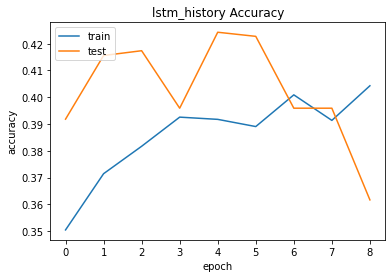

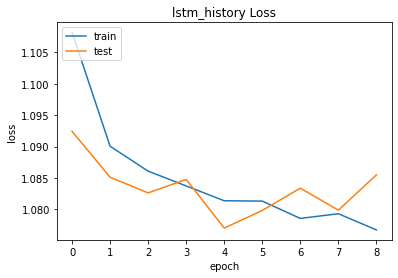

       loss  accuracy  val_loss  val_accuracy
0  1.108203  0.350416  1.092436      0.391816
1  1.090061  0.371429  1.085129      0.415601
2  1.086093  0.381678  1.082633      0.417391
3  1.083740  0.392569  1.084776      0.395908
4  1.081381  0.391736  1.077036      0.424297
5  1.081326  0.389045  1.079834      0.422762
6  1.078569  0.400897  1.083388      0.395908
7  1.079314  0.391352  1.079882      0.395908
8  1.076739  0.404292  1.085502      0.361637


In [ ]:
## Visualize Results      source: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

# summarize lstm_history for accuracy
plt.plot(simple_lstm_history.history['accuracy'])
plt.plot(simple_lstm_history.history['val_accuracy'])
plt.title('lstm_history Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize lstm_history for loss
plt.plot(simple_lstm_history.history['loss'])
plt.plot(simple_lstm_history.history['val_loss'])
plt.title('lstm_history Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

history_pd = pd.DataFrame(simple_lstm_history.history)
print(history_pd)


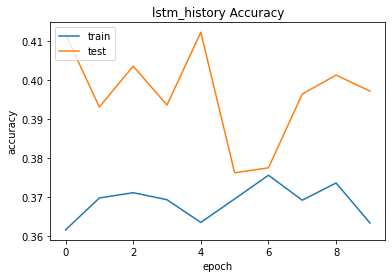

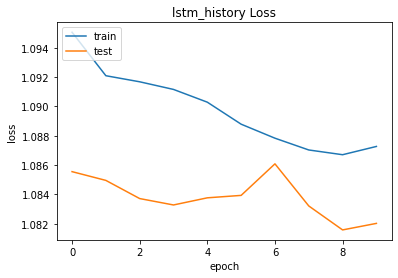

       loss  accuracy  val_loss  val_accuracy
0  1.095065  0.361563  1.085555      0.411765
1  1.092099  0.369763  1.084957      0.393095
2  1.091685  0.371108  1.083718      0.403581
3  1.091164  0.369315  1.083281      0.393606
4  1.090294  0.363485  1.083769      0.412276
5  1.088793  0.369507  1.083935      0.376215
6  1.087837  0.375593  1.086087      0.377494
7  1.087033  0.369186  1.083214      0.396419
8  1.086710  0.373607  1.081579      0.401279
9  1.087274  0.363357  1.082024      0.397187


In [ ]:
## Visualize Results      source: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

# summarize lstm_history for accuracy
plt.plot(complex_lstm_history.history['accuracy'])
plt.plot(complex_lstm_history.history['val_accuracy'])
plt.title('lstm_history Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize lstm_history for loss
plt.plot(complex_lstm_history.history['loss'])
plt.plot(complex_lstm_history.history['val_loss'])
plt.title('lstm_history Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

history_pd = pd.DataFrame(complex_lstm_history.history)
print(history_pd)
